# Claims Severity Prediction by Fine-Tuning a Foundation Model
## 1. Data Assembly & Exploration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('train.csv')

print("=== BASIC PANDAS PROFILING FOR NUMERIC COLUMNS ===")
print(f"Dataset shape: {df.shape}")

# Identify numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64', 'int32', 'float32']).columns
print(f"\nNumeric columns found: {len(numeric_columns)}")
print(f"Column names: {numeric_columns.tolist()}")

print("\n" + "="*70)

# Profile each numeric column
for col in numeric_columns:
    print(f"\n📊 COLUMN: {col}")
    print("-" * 50)
    
    # Basic statistics
    print("📈 Descriptive Statistics:")
    print(df[col].describe())
    
    # Data quality
    print(f"\n🔍 Data Quality:")
    print(f"   • Null values: {df[col].isnull().sum()} ({df[col].isnull().sum()/len(df)*100:.2f}%)")
    print(f"   • Unique values: {df[col].nunique()}")
    print(f"   • Data type: {df[col].dtype}")
    
    # Additional insights
    if df[col].nunique() > 1:  # Avoid division by zero
        print(f"   • Range: {df[col].max() - df[col].min():.2f}")
        print(f"   • Coefficient of Variation: {df[col].std()/df[col].mean()*100:.2f}%")
    
    # Check for potential outliers (using IQR method)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"   • Potential outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    
    print("=" * 50)

print(f"\n✅ Profiling completed for {len(numeric_columns)} numeric columns!")

=== BASIC PANDAS PROFILING FOR NUMERIC COLUMNS ===
Dataset shape: (54000, 15)

Numeric columns found: 8
Column names: ['Age', 'DependentChildren', 'DependentsOther', 'WeeklyWages', 'HoursWorkedPerWeek', 'DaysWorkedPerWeek', 'InitialIncurredCalimsCost', 'UltimateIncurredClaimCost']


📊 COLUMN: Age
--------------------------------------------------
📈 Descriptive Statistics:
count    54000.000000
mean        33.842370
std         12.122165
min         13.000000
25%         23.000000
50%         32.000000
75%         43.000000
max         81.000000
Name: Age, dtype: float64

🔍 Data Quality:
   • Null values: 0 (0.00%)
   • Unique values: 68
   • Data type: int64
   • Range: 68.00
   • Coefficient of Variation: 35.82%
   • Potential outliers: 22 (0.04%)

📊 COLUMN: DependentChildren
--------------------------------------------------
📈 Descriptive Statistics:
count    54000.000000
mean         0.119185
std          0.517780
min          0.000000
25%          0.000000
50%          0.000000
75%

## Numerical Columns Profiling Analysis

### Dataset Overview
- **Total Records:** 54,000 
- **Numerical Columns:** 8 columns
- **Data Quality:** Excellent - Zero missing values across all features

---

### Detailed Analysis of All Numerical Features

#### **Demographic Features**

**1. Age**
- **Mean:** 33.8 years | **Range:** 13-81 years (68 years span)
- **Distribution:** Well-balanced (CV: 35.82%)
- **Quality:** Minimal outliers (0.04%) - excellent for modeling

**2. DependentChildren**
- **Mean:** 0.12 children | **Range:** 0-9 children
- **Distribution:** Highly skewed - 75% have no children (CV: 434%)
- **Outliers:** 6.22% - natural for count data pattern

**3. DependentsOther**
- **Mean:** 0.01 individuals | **Range:** 0-5 dependents  
- **Distribution:** Extremely sparse (CV: 1099%) - 99% have zero
- **Recommendation:** Consider removal due to low information value

---

#### **Employment & Economic Features**

**4. WeeklyWages**
- **Mean:** $416.36 | **Median:** $392.20 | **Range:** $1-$7,497
- **Distribution:** Right-skewed (CV: 59.72%) - typical wage distribution
- **Outliers:** 2.74% - high earners, manageable level
- **Insights:** Most workers earn $200-$500/week (Q1-Q3)

**5. HoursWorkedPerWeek** ⚠️
- **Mean:** 37.7 hours | **Median:** 38 hours | **Range:** 0-640 hours
- **Distribution:** Clustered around full-time (CV: 33.31%)
- **Critical Issue:** 13.79% outliers - some unrealistic values (640+ hours)
- **Action Required:** Cap extreme values or investigate data quality

**6. DaysWorkedPerWeek**
- **Mean:** 4.9 days | **Median:** 5 days | **Range:** 1-7 days
- **Distribution:** Very stable (CV: 11.25%) - mostly standard work week
- **Outliers:** 8.92% - likely weekend/shift workers

---

#### **Claim Cost Features (Critical for Prediction)**

**7. InitialIncurredClaimsCost**
- **Mean:** $7,841 | **Median:** $2,000 | **Range:** $1-$2M
- **Distribution:** Heavily right-skewed (CV: 262.51%)
- **Outliers:** 8.06% - high-cost initial assessments
- **Pattern:** Mean >> Median indicates extreme skewness

**8. UltimateIncurredClaimCost** **[TARGET VARIABLE]**
- **Mean:** $11,003 | **Median:** $3,371 | **Range:** $122-$4.03M
- **Distribution:** Extremely right-skewed (CV: 303.46%)
- **Outliers:** 12.60% - highest among all features
- **Critical Insight:** Claims escalate from initial ($7.8K) to ultimate ($11K) on average

---

### Key Data Insights

#### **Distribution Patterns:**
- **Normal/Balanced:** Age, DaysWorkedPerWeek
- **Right-Skewed:** WeeklyWages, Cost variables
- **Highly Sparse:** DependentChildren, DependentsOther
- **Clustered:** HoursWorkedPerWeek around 38-40 hours

#### **Data Quality Issues:**
1. **HoursWorkedPerWeek:** Unrealistic maximum (640 hours) needs investigation
2. **Cost Variables:** Extreme outliers but expected in insurance data
3. **Dependent Variables:** Very sparse, limited predictive value

---

### **Comprehensive Preprocessing Strategy**

#### **Feature Transformations:**

**1. Log Transformation Required:**
- WeeklyWages, InitialIncurredClaimsCost, UltimateIncurredClaimCost
- *Reason:* Heavy right-skewness (CV > 100%)

**2. Outlier Treatment:**
- **HoursWorkedPerWeek:** Cap at reasonable maximum (80 hours)
- **Cost Variables:** Use robust scaling methods
- **Age:** Minimal outliers, keep as-is

**3. Feature Engineering:**
- **Hourly Rate:** WeeklyWages ÷ HoursWorkedPerWeek
- **Cost Escalation:** UltimateIncurredClaimCost ÷ InitialIncurredClaimsCost
- **Work Intensity:** Categorical encoding for hours/days patterns

**4. Scaling Strategy:**
- **StandardScaler:** Age, work pattern features
- **RobustScaler:** Cost variables (outlier-resistant)
- **LogNormal:** Wage and cost variables after log transformation

### Handling Outliers

In [3]:
from sklearn.preprocessing import RobustScaler

print("=== DATA PREPROCESSING: OUTLIER TREATMENT & SCALING ===")
print(f"Original dataset shape: {df.shape}")

# HOURS WORKED PER WEEK - CAPPING AT 100 HOURS
print("\n🕐 HOURS WORKED PER WEEK - OUTLIER TREATMENT")
print("-" * 60)

hours_col = 'HoursWorkedPerWeek'
print(f"Original {hours_col} statistics:")
print(df[hours_col].describe())

# Check extreme values
extreme_hours = df[df[hours_col] > 100]
print(f"\nRecords with >100 hours: {len(extreme_hours)} ({len(extreme_hours)/len(df)*100:.2f}%)")
print(f"Values >100 hours: {sorted(extreme_hours[hours_col].unique())}")

# Show some extreme examples
if len(extreme_hours) > 0:
    print("\nExamples of extreme hours:")
    sample_extreme = extreme_hours.head(5)[[hours_col, 'WeeklyWages', 'ClaimDescription']]
    for idx, row in sample_extreme.iterrows():
        print(f"  {row[hours_col]} hours, ${row['WeeklyWages']:.0f}/week: {row['ClaimDescription'][:50]}...")

# Apply capping
df_processed = df.copy()
df_processed[hours_col] = df_processed[hours_col].clip(upper=100)

print(f"\nAfter capping at 100 hours:")
print(f"  Records modified: {(df[hours_col] > 100).sum()}")
print(f"  New max hours: {df_processed[hours_col].max()}")
print(f"  New statistics:")
print(df_processed[hours_col].describe())

=== DATA PREPROCESSING: OUTLIER TREATMENT & SCALING ===
Original dataset shape: (54000, 15)

🕐 HOURS WORKED PER WEEK - OUTLIER TREATMENT
------------------------------------------------------------
Original HoursWorkedPerWeek statistics:
count    54000.000000
mean        37.735084
std         12.568704
min          0.000000
25%         38.000000
50%         38.000000
75%         40.000000
max        640.000000
Name: HoursWorkedPerWeek, dtype: float64

Records with >100 hours: 37 (0.07%)
Values >100 hours: [np.float64(168.0), np.float64(250.0), np.float64(319.8), np.float64(320.0), np.float64(338.0), np.float64(350.0), np.float64(360.0), np.float64(380.0), np.float64(383.0), np.float64(385.0), np.float64(387.0), np.float64(389.0), np.float64(400.0), np.float64(410.0), np.float64(417.2), np.float64(450.0), np.float64(462.08), np.float64(538.3), np.float64(627.0), np.float64(638.0), np.float64(640.0)]

Examples of extreme hours:
  250.0 hours, $338/week: WELDING FLASH FROM WELDER SORE EYE

### Transformation and Scaling

In [4]:
# COST VARIABLES - ROBUST SCALING
print("\n💰 COST VARIABLES - ROBUST SCALING")
print("-" * 60)

cost_columns = ['InitialIncurredCalimsCost', 'UltimateIncurredClaimCost']

# Analyze original distributions
print("Original cost variable distributions:")
for col in cost_columns:
    print(f"\n{col}:")
    print(f"  Mean: ${df[col].mean():,.2f}")
    print(f"  Median: ${df[col].median():,.2f}")
    print(f"  Std: ${df[col].std():,.2f}")
    print(f"  Min: ${df[col].min():,.2f}")
    print(f"  Max: ${df[col].max():,.2f}")
    print(f"  Skewness: {df[col].skew():.2f}")
    
    # Count of extreme outliers (>99th percentile)
    p99 = df[col].quantile(0.99)
    extreme_count = (df[col] > p99).sum()
    print(f"  Values above 99th percentile (${p99:,.0f}): {extreme_count} ({extreme_count/len(df)*100:.2f}%)")

# Apply Log Transformation first (for right-skewed variables)
log_transform_columns = ['WeeklyWages'] + cost_columns
print(f"\nApplying Log Transformation to: {log_transform_columns}")

for col in log_transform_columns:
    # Add small constant to avoid log(0)
    df_processed[f'{col}_Log'] = np.log1p(df[col])  # log1p = log(1+x)
    
    print(f"\n{col} → {col}_Log:")
    print(f"  Original skewness: {df[col].skew():.2f}")
    print(f"  Log-transformed skewness: {df_processed[f'{col}_Log'].skew():.2f}")
    print(f"  Skewness improvement: {abs(df[col].skew()) - abs(df_processed[f'{col}_Log'].skew()):.2f}")

# Apply robust scaling to log-transformed cost variables
scaler = RobustScaler()
log_cost_columns = [f'{col}_Log' for col in cost_columns]
cost_log_data = df_processed[log_cost_columns].values
cost_log_scaled = scaler.fit_transform(cost_log_data)

# Add scaled columns to dataframe
for i, col in enumerate(cost_columns):
    df_processed[f'{col}_LogRobustScaled'] = cost_log_scaled[:, i]

print(f"\nRobust Scaling Results:")
print("Robust Scaler parameters:")
print(f"  Median (center): {scaler.center_}")
print(f"  IQR (scale): {scaler.scale_}")

print(f"\nLog-transformed and scaled cost variables statistics:")
for i, col in enumerate(cost_columns):
    scaled_col = f'{col}_LogRobustScaled'
    print(f"\n{scaled_col}:")
    print(f"  Mean: {df_processed[scaled_col].mean():.4f}")
    print(f"  Median: {df_processed[scaled_col].median():.4f}")
    print(f"  Std: {df_processed[scaled_col].std():.4f}")
    print(f"  Min: {df_processed[scaled_col].min():.4f}")
    print(f"  Max: {df_processed[scaled_col].max():.4f}")

# Also show WeeklyWages log transformation stats
print(f"\nWeeklyWages_Log statistics:")
wages_log_stats = df_processed['WeeklyWages_Log'].describe()
print(wages_log_stats)


💰 COST VARIABLES - ROBUST SCALING
------------------------------------------------------------
Original cost variable distributions:

InitialIncurredCalimsCost:
  Mean: $7,841.15
  Median: $2,000.00
  Std: $20,584.08
  Min: $1.00
  Max: $2,000,000.00
  Skewness: 26.85
  Values above 99th percentile ($75,000): 534 (0.99%)

UltimateIncurredClaimCost:
  Mean: $11,003.37
  Median: $3,371.24
  Std: $33,390.99
  Min: $121.89
  Max: $4,027,135.94
  Skewness: 37.55
  Values above 99th percentile ($139,025): 540 (1.00%)

Applying Log Transformation to: ['WeeklyWages', 'InitialIncurredCalimsCost', 'UltimateIncurredClaimCost']

WeeklyWages → WeeklyWages_Log:
  Original skewness: 4.12
  Log-transformed skewness: -2.09
  Skewness improvement: 2.03

InitialIncurredCalimsCost → InitialIncurredCalimsCost_Log:
  Original skewness: 26.85
  Log-transformed skewness: 0.21
  Skewness improvement: 26.64

UltimateIncurredClaimCost → UltimateIncurredClaimCost_Log:
  Original skewness: 37.55
  Log-transformed

### Feature Engineering

In [5]:
# FEATURE ENGINEERING: ADDITIONAL DERIVED FEATURES
print("\n FEATURE ENGINEERING: DERIVED FEATURES")
print("-" * 60)

# Hourly wage calculation (with safe division)
df_processed['HourlyWage'] = df_processed['WeeklyWages'] / df_processed[hours_col].replace(0, np.nan)
# Also create log-transformed hourly wage
df_processed['HourlyWage_Log'] = np.log1p(df_processed['HourlyWage'].fillna(0))

hourly_wage_stats = df_processed['HourlyWage'].describe()
print("New feature: HourlyWage")
print(hourly_wage_stats)
print(f"HourlyWage skewness: {df_processed['HourlyWage'].skew():.2f}")
print(f"HourlyWage_Log skewness: {df_processed['HourlyWage_Log'].skew():.2f}")

# Cost escalation ratio
df_processed['CostEscalationRatio'] = (df_processed['UltimateIncurredClaimCost'] / 
                                      df_processed['InitialIncurredCalimsCost'].replace(0, np.nan))
escalation_stats = df_processed['CostEscalationRatio'].describe()
print(f"\nNew feature: CostEscalationRatio")
print(escalation_stats)

# Work intensity categorization
def categorize_work_intensity(hours):
    if hours <= 20:
        return 'Part-time'
    elif hours <= 40:
        return 'Standard'
    elif hours <= 50:
        return 'Extended'
    else:
        return 'Intensive'

df_processed['WorkIntensityCategory'] = df_processed[hours_col].apply(categorize_work_intensity)
work_intensity_dist = df_processed['WorkIntensityCategory'].value_counts()
print(f"\nNew feature: WorkIntensityCategory")
print(work_intensity_dist)


 FEATURE ENGINEERING: DERIVED FEATURES
------------------------------------------------------------
New feature: HourlyWage
count    53971.000000
mean        11.312875
std          7.839644
min          0.014286
25%          5.714286
50%         10.560526
75%         13.611539
max        519.200000
Name: HourlyWage, dtype: float64
HourlyWage skewness: 13.27
HourlyWage_Log skewness: -0.39

New feature: CostEscalationRatio
count    54000.000000
mean         4.986533
std        113.925455
min          0.043632
25%          0.751631
50%          1.063106
75%          1.806784
max       8763.805521
Name: CostEscalationRatio, dtype: float64

New feature: WorkIntensityCategory
WorkIntensityCategory
Standard     48989
Part-time     2543
Extended      1430
Intensive     1038
Name: count, dtype: int64


In [6]:
# SAVE PROCESSED DATA
print("\n SAVING PROCESSED DATA")
print("-" * 60)

# Save the processed training data
output_file = 'train_processed.csv'
df_processed.to_csv(output_file, index=False)
print(f"Processed training data saved to: {output_file}")
print(f"New dataset shape: {df_processed.shape}")
print(f"New columns added: {df_processed.shape[1] - df.shape[1]}")

print("\nNew columns created:")
new_columns = [col for col in df_processed.columns if col not in df.columns]
for col in new_columns:
    print(f"  • {col}")


 SAVING PROCESSED DATA
------------------------------------------------------------
Processed training data saved to: train_processed.csv
New dataset shape: (54000, 24)
New columns added: 9

New columns created:
  • WeeklyWages_Log
  • InitialIncurredCalimsCost_Log
  • UltimateIncurredClaimCost_Log
  • InitialIncurredCalimsCost_LogRobustScaled
  • UltimateIncurredClaimCost_LogRobustScaled
  • HourlyWage
  • HourlyWage_Log
  • CostEscalationRatio
  • WorkIntensityCategory


## NLP-specific stats

In [7]:
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer

descriptions = df['ClaimDescription'].fillna('')

print("=== NLP-SPECIFIC STATISTICS FOR CLAIM DESCRIPTIONS ===")
print(f"Total descriptions: {len(descriptions)}")
print(f"Empty descriptions: {descriptions.str.strip().eq('').sum()}")

# TOKEN LENGTH ANALYSIS
print("\n TOKEN LENGTH ANALYSIS")
print("-" * 50)
token_lengths = descriptions.str.split().str.len()
print(f"Average tokens per description: {token_lengths.mean():.2f}")
print(f"Median tokens: {token_lengths.median():.1f}")
print(f"Min tokens: {token_lengths.min()}")
print(f"Max tokens: {token_lengths.max()}")
print(f"Standard deviation: {token_lengths.std():.2f}")

# Character length analysis
char_lengths = descriptions.str.len()
print(f"\nAverage characters per description: {char_lengths.mean():.2f}")
print(f"Max characters: {char_lengths.max()}")

# TOP N-GRAMS ANALYSIS
print("\n TOP N-GRAMS ANALYSIS")
print("-" * 50)

# Clean text function
def clean_text(text):
    # Convert to uppercase and remove extra spaces
    text = str(text).upper().strip()
    # Remove special characters but keep spaces
    text = re.sub(r'[^A-Z\s]', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    return text

# Clean descriptions
cleaned_descriptions = descriptions.apply(clean_text)

# Top 1-grams (words)
all_words = ' '.join(cleaned_descriptions).split()
top_words = Counter(all_words).most_common(15)
print("Top 15 Words (1-grams):")
for word, count in top_words:
    print(f"  '{word}': {count} times ({count/len(descriptions)*100:.2f}% of descriptions)")

# Top 2-grams
vectorizer_2gram = CountVectorizer(ngram_range=(2, 2), max_features=10)
try:
    vectorizer_2gram.fit(cleaned_descriptions)
    feature_names = vectorizer_2gram.get_feature_names_out()
    word_count_vector = vectorizer_2gram.transform(cleaned_descriptions)
    word_counts = word_count_vector.sum(axis=0).A1
    top_2grams = [(feature_names[i], word_counts[i]) for i in word_counts.argsort()[-10:][::-1]]
    
    print("\nTop 10 2-grams:")
    for phrase, count in top_2grams:
        print(f"  '{phrase}': {count} times")
except:
    print("\nCould not generate 2-grams (insufficient data)")

# 3. VOCABULARY ANALYSIS
print("\n VOCABULARY ANALYSIS")
print("-" * 50)
unique_words = set(all_words)
print(f"Total unique words (vocabulary size): {len(unique_words)}")
print(f"Total word instances: {len(all_words)}")
print(f"Vocabulary richness: {len(unique_words)/len(all_words):.4f}")

# Most frequent word categories (injury-related)
injury_words = [word for word in all_words if 'INJUR' in word or 'HURT' in word or 'PAIN' in word]
body_parts = [word for word in all_words if any(part in word for part in ['ARM', 'LEG', 'BACK', 'HAND', 'FINGER', 'HEAD', 'NECK', 'SHOULDER'])]
actions = [word for word in all_words if any(action in word for action in ['LIFT', 'FALL', 'CUT', 'HIT', 'SLIP', 'TWIST'])]

print(f"\nDomain-specific word categories:")
print(f"  Injury-related words: {len(injury_words)} instances")
print(f"  Body part mentions: {len(body_parts)} instances")
print(f"  Action words: {len(actions)} instances")

=== NLP-SPECIFIC STATISTICS FOR CLAIM DESCRIPTIONS ===
Total descriptions: 54000
Empty descriptions: 0

 TOKEN LENGTH ANALYSIS
--------------------------------------------------
Average tokens per description: 7.02
Median tokens: 7.0
Min tokens: 1
Max tokens: 14
Standard deviation: 1.65

Average characters per description: 43.45
Max characters: 94

 TOP N-GRAMS ANALYSIS
--------------------------------------------------
Top 15 Words (1-grams):
  'RIGHT': 22648 times (41.94% of descriptions)
  'LEFT': 20756 times (38.44% of descriptions)
  'BACK': 16346 times (30.27% of descriptions)
  'STRAIN': 15259 times (28.26% of descriptions)
  'LOWER': 9950 times (18.43% of descriptions)
  'AND': 9103 times (16.86% of descriptions)
  'FINGER': 8584 times (15.90% of descriptions)
  'LIFTING': 8300 times (15.37% of descriptions)
  'HAND': 7723 times (14.30% of descriptions)
  'STRUCK': 7354 times (13.62% of descriptions)
  'SHOULDER': 6198 times (11.48% of descriptions)
  'FELL': 5747 times (10.64%

### Visualization

C:\Users\sghas\AppData\Local\Temp\ipykernel_24136\4012296501.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, original_col].boxplot(box_data_original, labels=['Original'])
C:\Users\sghas\AppData\Local\Temp\ipykernel_24136\4012296501.py:52: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, log_col].boxplot([box_data_log[0], box_data_scaled[0]], labels=['Log', 'Log+Scaled'])
C:\Users\sghas\AppData\Local\Temp\ipykernel_24136\4012296501.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, original_col].boxplot(box_data_original, labels=['Original'])
C:\Users\sghas\AppData\Local\Temp\ipykernel_24136

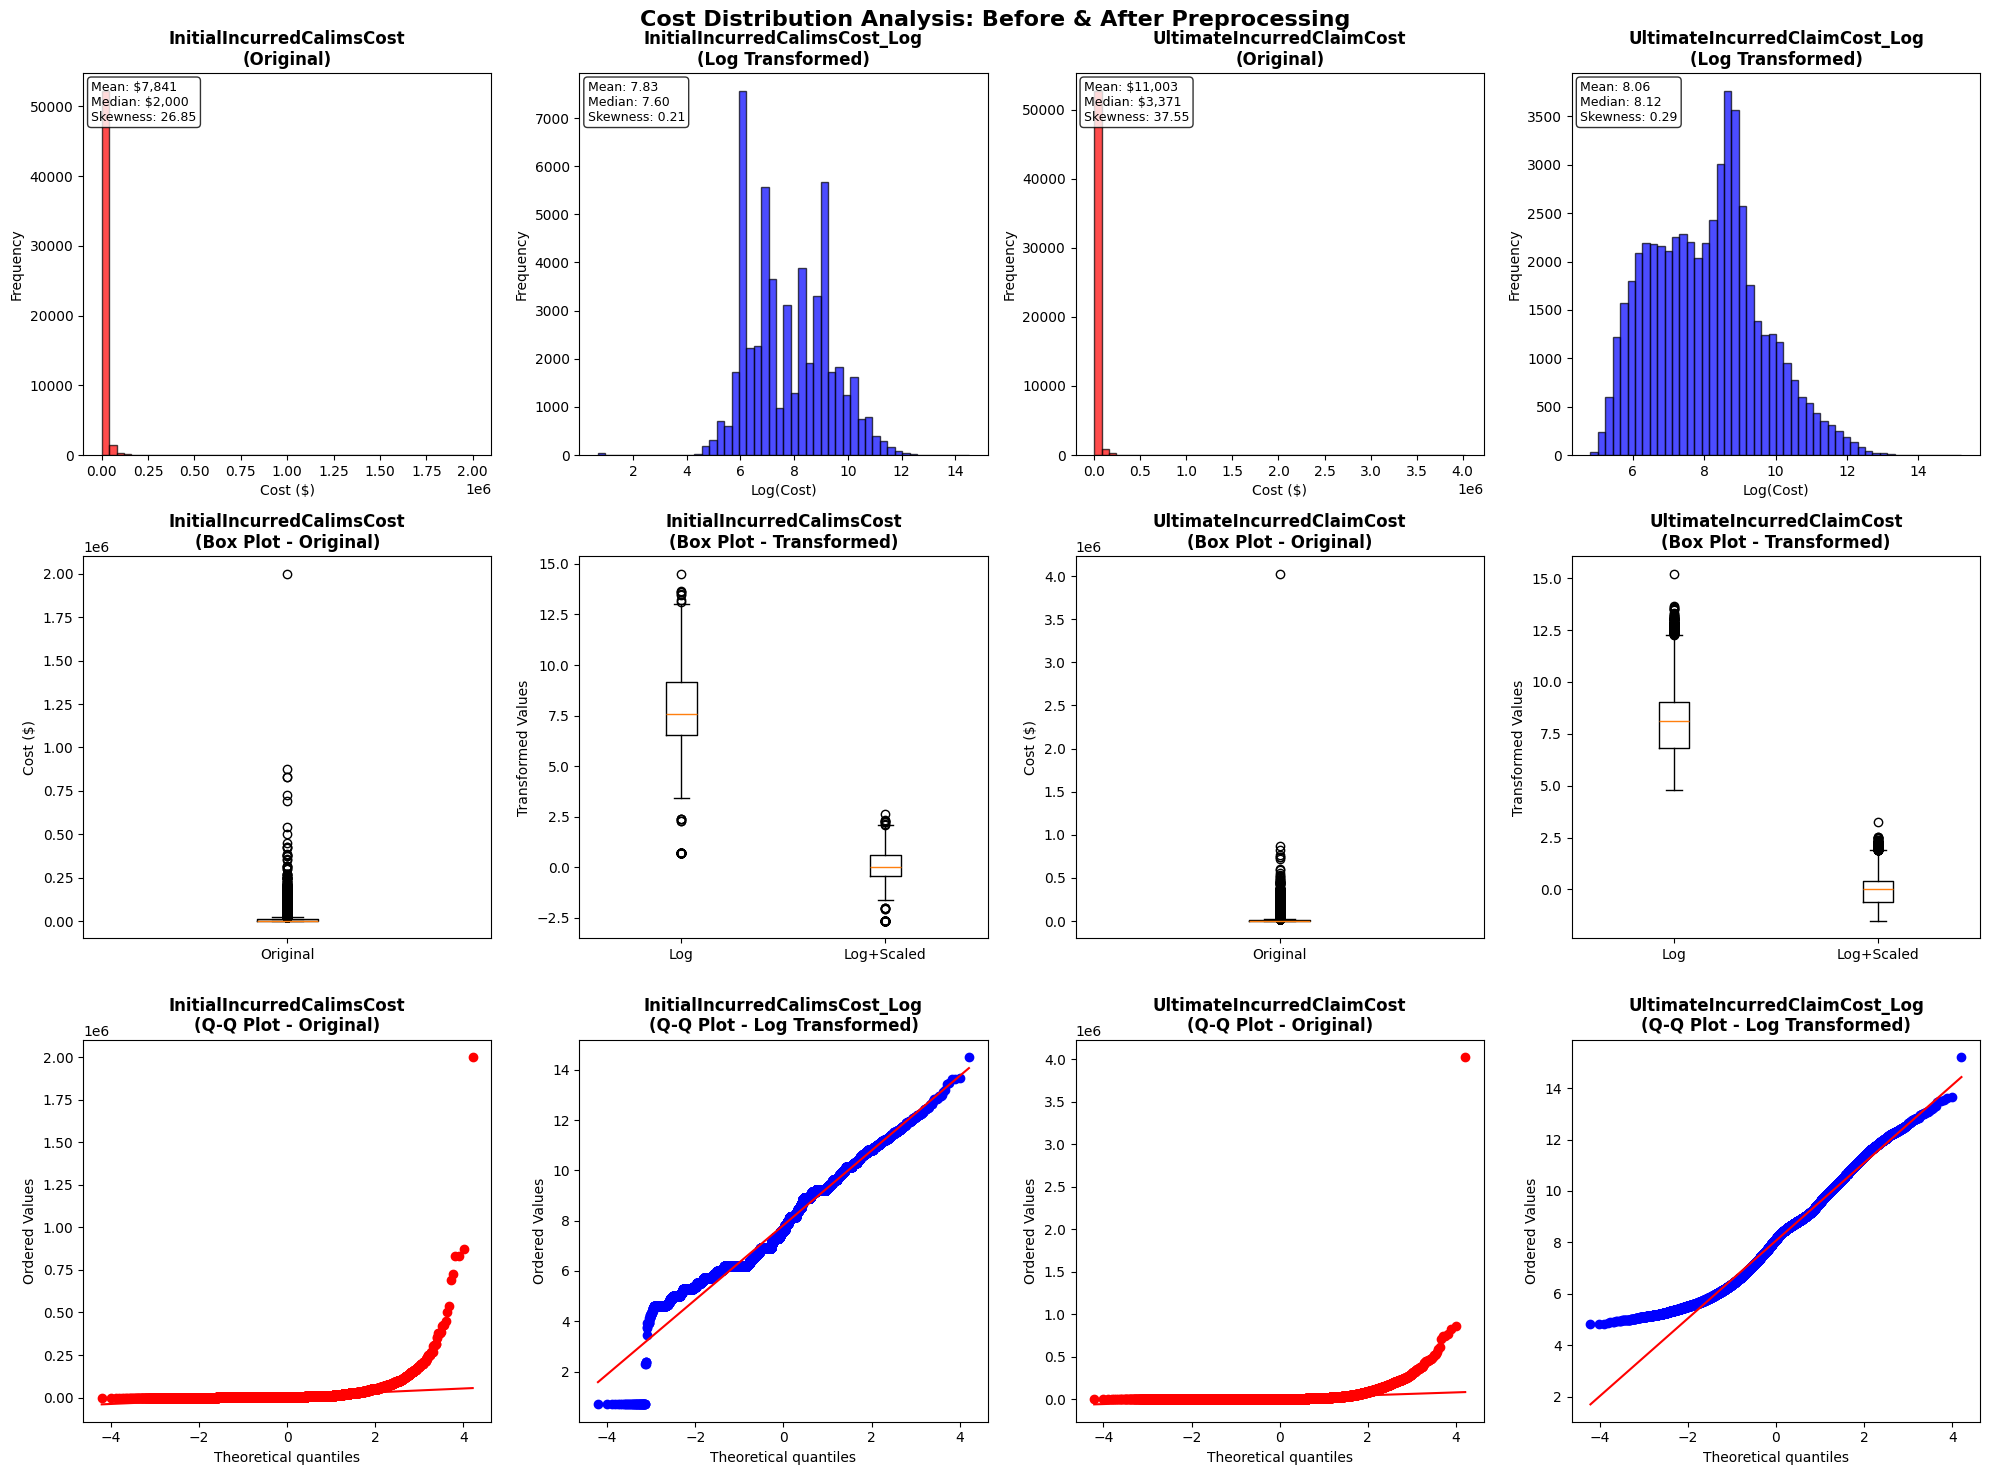

In [8]:
import seaborn as sns
from scipy import stats

# Create comprehensive visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('Cost Distribution Analysis: Before & After Preprocessing', fontsize=16, fontweight='bold')

for i, col in enumerate(cost_columns):
    # Original data column
    original_col = i * 2
    log_col = i * 2 + 1
    
    # Row 1: Histograms - Original vs Log-transformed
    axes[0, original_col].hist(df[col], bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[0, original_col].set_title(f'{col}\n(Original)', fontweight='bold')
    axes[0, original_col].set_xlabel('Cost ($)')
    axes[0, original_col].set_ylabel('Frequency')
    axes[0, original_col].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))
    
    # Add statistics text
    mean_val = df[col].mean()
    median_val = df[col].median()
    skew_val = df[col].skew()
    axes[0, original_col].text(0.02, 0.98, f'Mean: ${mean_val:,.0f}\nMedian: ${median_val:,.0f}\nSkewness: {skew_val:.2f}', 
                              transform=axes[0, original_col].transAxes, fontsize=9, verticalalignment='top',
                              bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Log-transformed
    axes[0, log_col].hist(df_processed[f'{col}_Log'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0, log_col].set_title(f'{col}_Log\n(Log Transformed)', fontweight='bold')
    axes[0, log_col].set_xlabel('Log(Cost)')
    axes[0, log_col].set_ylabel('Frequency')
    
    # Add statistics for log-transformed
    log_mean = df_processed[f'{col}_Log'].mean()
    log_median = df_processed[f'{col}_Log'].median()
    log_skew = df_processed[f'{col}_Log'].skew()
    axes[0, log_col].text(0.02, 0.98, f'Mean: {log_mean:.2f}\nMedian: {log_median:.2f}\nSkewness: {log_skew:.2f}', 
                         transform=axes[0, log_col].transAxes, fontsize=9, verticalalignment='top',
                         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Row 2: Box plots - Original vs Log vs Scaled
    box_data_original = [df[col]]
    box_data_log = [df_processed[f'{col}_Log']]
    box_data_scaled = [df_processed[f'{col}_LogRobustScaled']]
    
    axes[1, original_col].boxplot(box_data_original, labels=['Original'])
    axes[1, original_col].set_title(f'{col}\n(Box Plot - Original)', fontweight='bold')
    axes[1, original_col].set_ylabel('Cost ($)')
    axes[1, original_col].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
    
    axes[1, log_col].boxplot([box_data_log[0], box_data_scaled[0]], labels=['Log', 'Log+Scaled'])
    axes[1, log_col].set_title(f'{col}\n(Box Plot - Transformed)', fontweight='bold')
    axes[1, log_col].set_ylabel('Transformed Values')
    
    # Row 3: Q-Q plots to check normality
    stats.probplot(df[col], dist="norm", plot=axes[2, original_col])
    axes[2, original_col].set_title(f'{col}\n(Q-Q Plot - Original)', fontweight='bold')
    axes[2, original_col].get_lines()[0].set_markerfacecolor('red')
    axes[2, original_col].get_lines()[0].set_markeredgecolor('red')
    
    stats.probplot(df_processed[f'{col}_Log'], dist="norm", plot=axes[2, log_col])
    axes[2, log_col].set_title(f'{col}_Log\n(Q-Q Plot - Log Transformed)', fontweight='bold')
    axes[2, log_col].get_lines()[0].set_markerfacecolor('blue')
    axes[2, log_col].get_lines()[0].set_markeredgecolor('blue')

plt.tight_layout()
plt.savefig('cost_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
